## PINNs for Steady Cavity Problem

Solving the 2D steady diffusion equation using a Physics Informed Neural Network (PINN).  

### Governing Equations

The equations for the 2D steady Navier-Stokes problem are given by:

$$
\begin{cases}
\cancel{\frac{\partial u}{\partial t}} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)  \\
\cancel{\frac{\partial v}{\partial t}} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
\end{cases}
$$



### Continuity Equation

The continuity equation for incompressible flow is:

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

### Momentum Equations

In terms of the components, the momentum equations are:

$$
u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + \frac{\partial p}{\partial x} = \frac{1}{Re} \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

$$
u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + \frac{\partial p}{\partial y} = \frac{1}{Re} \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
$$

where \( Re \) is the Reynolds number.

### Domain

The domain for x and y is:
$$
 x \in [0,1] \quad \text{and } \quad  y \in [0,1] .
$$

### Initial and Boundary Conditions

The boundary conditions (BCs) for this problem are as follows:

- For \( u \) and \( v \):

$$
u(0, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
u(1, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
u(x, 0) = 0 \quad \text{for } x \in [0, 1]
$$

$$
u(x, 1) = u_i \quad \text{for } x \in [0, 1] \quad (u_i \text{ is the top wall's velocity})
$$

$$
v(0, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
v(1, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
v(x, 0) = 0 \quad \text{for } x \in [0, 1]
$$

$$
v(x, 1) = 0 \quad \text{for } x \in [0, 1]
$$

### Loss Function for PINN

In the context of a Physics Informed Neural Network (PINN), the loss function includes terms to enforce these equations and boundary conditions:

- Residuals of the Navier-Stokes equations and continuity equation.
- Boundary conditions for \( u \) and \( v \).

The loss function can be represented as:

$$
\text{Loss} = \text{Loss}{\text{equations}} + \text{Loss}{\text{boundary conditions}}
$$

Where:
- $ \text{Loss}_{\text{equations}} $ ensures that the predicted solutions satisfy the Navier-Stokes and continuity equations.
- $ \text{Loss}_{\text{boundary conditions}} $ ensures that the boundary conditions are met.


In [2]:
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda:3")     # NVIDIA GPUs
elif torch.backends.mps.is_available():
    device = torch.device("mps")        # Apple silicon (metal performance shaders)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda:3


### Define PINNs network class with Fourier Feature Mapping

In [13]:
class ffm(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.B = nn.Parameter(torch.normal(mean=0, std=10, size=(in_dim, out_dim), requires_grad=False))
    
    def forward(self, x):
        x_map = torch.matmul(x, self.B)
        return torch.cat([torch.cos(x_map), torch.sin(x_map)], -1)

class PINNs_net(nn.Module):
    def __init__(self, in_dim=2, HL_dim=64, out_dim=3, activation=nn.Tanh()):
        super().__init__()

        network = [ffm(in_dim, HL_dim),
                   nn.Linear(HL_dim*2, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, out_dim)]
        
        # define the network using sequential method
        self.net = nn.Sequential(*network).to(device)
        
    def forward(self, x, y):
        return self.net(torch.cat((x, y), 1))
    

    def compute_loss(self, x, y, Nx, Ny, u_i):
        """
        This is the physics part really
        """
        Re = 100
        x.requires_grad=True
        y.requires_grad=True
        net_out = self.net(torch.cat((x,y), 1))   # input size: [Nx*Ny,2], output size: [Nx*Ny,3]

        u = net_out[:,0].view(-1,1)
        v = net_out[:,1].view(-1,1)
        p = net_out[:,2].view(-1,1)
 
        u_x   = grad(u, x, grad_outputs=torch.ones_like(x), create_graph=True, only_inputs=True)[0]
        v_x   = grad(v, x, grad_outputs=torch.ones_like(x), create_graph=True, only_inputs=True)[0]
        p_x   = grad(p, x, grad_outputs=torch.ones_like(x), create_graph=True, only_inputs=True)[0]
        u_y   = grad(u, y, grad_outputs=torch.ones_like(y), create_graph=True, only_inputs=True)[0]
        v_y   = grad(v, y, grad_outputs=torch.ones_like(y), create_graph=True, only_inputs=True)[0]
        p_y   = grad(p, y, grad_outputs=torch.ones_like(y), create_graph=True, only_inputs=True)[0]
        
        u_xx  = grad(u_x, x, grad_outputs=torch.ones_like(x), create_graph=True, only_inputs=True)[0]
        v_xx  = grad(v_x, x, grad_outputs=torch.ones_like(x), create_graph=True, only_inputs=True)[0]
        u_yy  = grad(u_y, y, grad_outputs=torch.ones_like(y), create_graph=True, only_inputs=True)[0]
        v_yy  = grad(v_y, y, grad_outputs=torch.ones_like(y), create_graph=True, only_inputs=True)[0]

        # set a loss function to apply to each of the physics residuals (PDE, IC, BC)
        loss_fun = nn.MSELoss()

        # compute the PDE residual loss
        res1 = u_x + v_y                                     # continuity
        res2 = u*u_x + v*u_y + p_x - 1.0/Re*(u_xx + u_yy)    # x-momentum
        res3 = u*v_x + v*v_y + p_y - 1.0/Re*(v_xx + v_yy)    # y-momentum
        pde_loss = loss_fun(res1, torch.zeros_like(res1)) + loss_fun(res2, torch.zeros_like(res2)) + loss_fun(res3, torch.zeros_like(res3))

        # compute the BC loss
        u_reshaped = u.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Ny]
        v_reshaped = v.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Ny]

        # Calculate indices for the boundary condition range
        bc_loss = loss_fun(u_reshaped[0, :], torch.zeros_like(u_reshaped[0,:])) \
                + loss_fun(u_reshaped[-1, :], torch.zeros_like(u_reshaped[Nx-1,:])) \
                + loss_fun(v_reshaped[0, :], torch.zeros_like(v_reshaped[0,:])) \
                + loss_fun(v_reshaped[-1, :], torch.zeros_like(v_reshaped[Nx-1,:])) \
                + loss_fun(u_reshaped[:, 0], torch.zeros_like(u_reshaped[:,Ny-1])) \
                + loss_fun(v_reshaped[:,0], torch.zeros_like(v_reshaped[:,Ny-1])) \
                + loss_fun(u_reshaped[:, -1], torch.ones_like(u_reshaped[:, -1]) * u_i) \
                + loss_fun(v_reshaped[:, -1], torch.zeros_like(v_reshaped[:, -1]))
       
        return pde_loss, bc_loss


### Define Model and Optimizer

In [14]:
model = PINNs_net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Setting up the Case

In [15]:
# num of points in the domain
Nx, Ny = 200, 200
u_i = 1 #m/s
# define domain dimensions and resolution
Lx_initial, Lx_final = 0, 1
Ly_initial, Ly_final = 0, 1

dx = (Lx_final - Lx_initial) / (Nx-1)
dy = (Ly_final - Ly_initial) / (Ny-1)

# initiallize input parameters as tensors
x = torch.zeros(Nx, Ny)
y = torch.zeros(Nx, Ny)

for i in range(Nx):
    for j in range(Ny):
        x[i,j] = Lx_initial + dx * i
        y[i,j] = Ly_initial + dy * j


x = x.to(device)
y = y.to(device)

### Training the PINNs network

In [16]:
N_epoches = 150000
loss_per_epoch = np.zeros((N_epoches,3))
for epoch in range(N_epoches):
    # compute various losses
    eq_loss, BC_loss = model.compute_loss(x.view(-1,1), y.view(-1,1), Nx, Ny, u_i)

    # compute total loss
    total_loss = eq_loss + 10*BC_loss

    # backward pass
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_per_epoch[epoch,0] = eq_loss
    loss_per_epoch[epoch,1] = BC_loss
    loss_per_epoch[epoch,2] = total_loss
    print(f"epoch: {epoch}, loss: {total_loss}")



epoch: 0, loss: 14.179247856140137
epoch: 1, loss: 11.822017669677734
epoch: 2, loss: 9.960588455200195
epoch: 3, loss: 8.437192916870117
epoch: 4, loss: 7.146753311157227
epoch: 5, loss: 6.021878242492676
epoch: 6, loss: 5.030180931091309
epoch: 7, loss: 4.1726531982421875
epoch: 8, loss: 3.475595712661743
epoch: 9, loss: 2.9702932834625244
epoch: 10, loss: 2.6597046852111816
epoch: 11, loss: 2.492877960205078
epoch: 12, loss: 2.3792543411254883
epoch: 13, loss: 2.2396044731140137
epoch: 14, loss: 2.0458621978759766
epoch: 15, loss: 1.8198045492172241
epoch: 16, loss: 1.6063883304595947
epoch: 17, loss: 1.4437721967697144
epoch: 18, loss: 1.3452434539794922
epoch: 19, loss: 1.3006503582000732
epoch: 20, loss: 1.288422703742981
epoch: 21, loss: 1.2860033512115479
epoch: 22, loss: 1.2757821083068848
epoch: 23, loss: 1.2478059530258179
epoch: 24, loss: 1.200369119644165
epoch: 25, loss: 1.1388909816741943
epoch: 26, loss: 1.0732793807983398
epoch: 27, loss: 1.0143264532089233
epoch: 28, 

<Figure size 640x480 with 0 Axes>

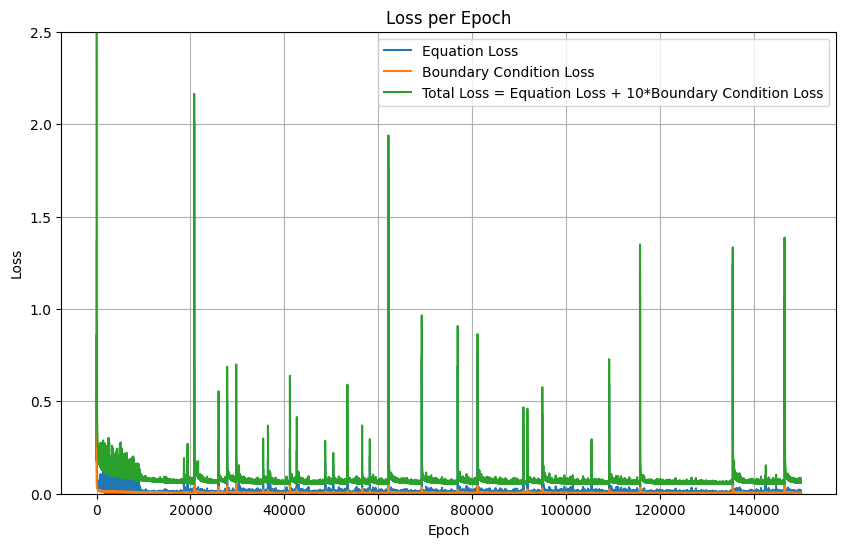

[[5.42779028e-01 1.36364686e+00 1.41792479e+01]
 [3.64508927e-01 1.14575088e+00 1.18220177e+01]
 [2.58987218e-01 9.70160067e-01 9.96058846e+00]
 ...
 [4.06530546e-03 5.75104030e-03 6.15757070e-02]
 [4.96179890e-03 5.74003253e-03 6.23621233e-02]
 [5.25394967e-03 5.74607728e-03 6.27147257e-02]]


In [8]:
N_epoches = 150000

epocs_array = np.linspace(1,N_epoches,N_epoches)
plt.clf()

plt.figure(figsize=(10, 6))  # Optional: specify the figure size

plt.ylim(0,2.5)

plt.plot(epocs_array, (loss_per_epoch[:,0]), '-')
plt.plot(epocs_array, (loss_per_epoch[:,1]), '-')
plt.plot(epocs_array, (loss_per_epoch[:,2]), '-')

plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.yscale('log')
plt.grid(True) 
plt.legend(['Equation Loss','Boundary Condition Loss','Total Loss = Equation Loss + 10*Boundary Condition Loss'])

# Show the plot
plt.show()
print(loss_per_epoch)

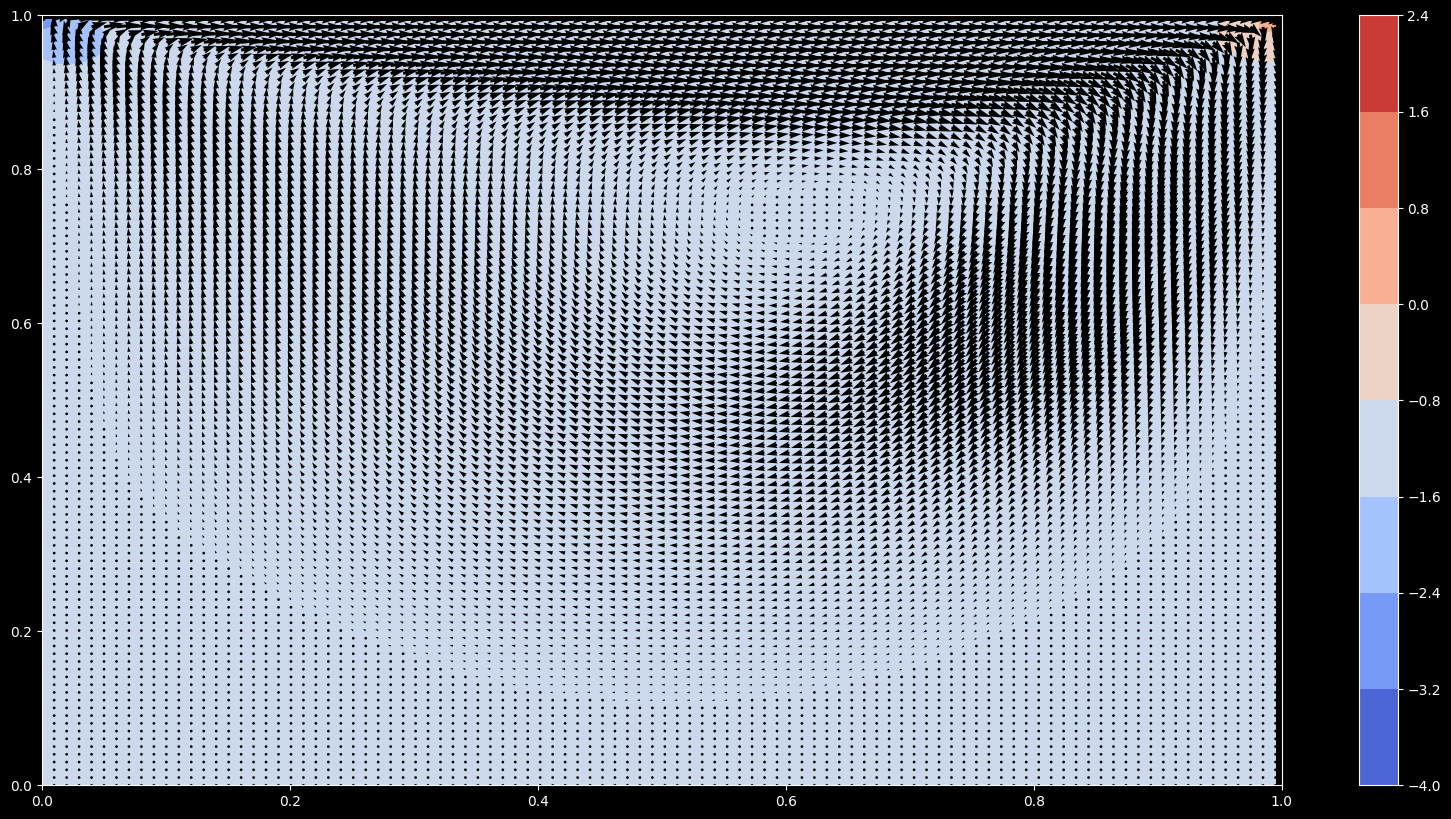

[0.5476698  0.79783833 0.94958687 0.99811655 1.0082307  1.00923
 1.0077416  1.0053946  1.0030502  1.0011086  0.99961185 0.99845225
 0.99750286 0.9966862  0.99597573 0.9953775  0.99490696 0.99457747
 0.99439394 0.99435    0.9944296  0.9946097  0.99486476 0.9951681
 0.9954959  0.995826   0.99614215 0.99643105 0.9966864  0.9969057
 0.9970891  0.9972458  0.9973819  0.99750835 0.9976352  0.99777114
 0.9979216  0.9980874  0.9982666  0.9984507  0.9986303  0.9987929
 0.9989263  0.9990202  0.9990682  0.999067   0.99901915 0.99893194
 0.9988162  0.99868786 0.99856246 0.9984571  0.9983832  0.99835056
 0.9983619  0.9984108  0.99849033 0.9985839  0.9986764  0.99875623
 0.9988149  0.9988541  0.9988799  0.9989036  0.9989351  0.9989819
 0.99904674 0.9991198  0.9991928  0.99925244 0.9992877  0.9992957
 0.9992776  0.99923867 0.99918675 0.9991295  0.9990705  0.99901026
 0.99894965 0.9988853  0.9988168  0.9987407  0.99866045 0.9985782
 0.9984988  0.9984292  0.998378   0.9983516  0.9983543  0.99838865
 0.9

In [21]:
#  x_np, y_np = np.meshgrid(x, y)
x_np = x.detach().cpu().numpy()
y_np = y.detach().cpu().numpy()

net = model.forward(x.view(-1,1), y.view(-1,1)) # convert x tensor into a column vector
u=net[:, 0]
v=net[:, 1]
p=net[:, 2]

u_np = 1*u.detach().cpu().numpy().reshape(Nx,Ny) # convert into a np array
v_np = 1*v.detach().cpu().numpy().reshape(Nx,Ny) # convert into a np array
p_np = p.detach().cpu().numpy().reshape(Nx,Ny) # convert into a np array


plt.style.use("dark_background")
plt.figure(figsize=(20, 10))
plt.contourf(x_np[::2,::2] , y_np[::2,::2], p_np[::2,::2], cmap="coolwarm")
plt.colorbar()


plt.quiver(x_np[::2,::2], y_np[::2,::2] , u_np[::2,::2] , v_np[::2,::2] , color="black", scale=25)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()
print(u_np[:,-1])

print("max u(x=0) : " , u_np[0,1:-1].max() )
print("max v(x=0) : " , v_np[0].max() )

In [19]:
#save the data as new .npz file
np.savez('PINNs_Caviti_workspace.npz', x_np=x_np,y_np=y_np,u_np=u_np,v_np=v_np,p_np=p_np,loss_per_epoch=loss_per_epoch)



# read data from .npz file


In [3]:
data = np.load('PINNs_Caviti_workspace.npz')

x_np= data['x_np']
y_np= data['y_np']
u_np= data['u_np']
v_np= data['v_np']
p_np= data['p_np']
loss_per_epoch= data['loss_per_epoch']

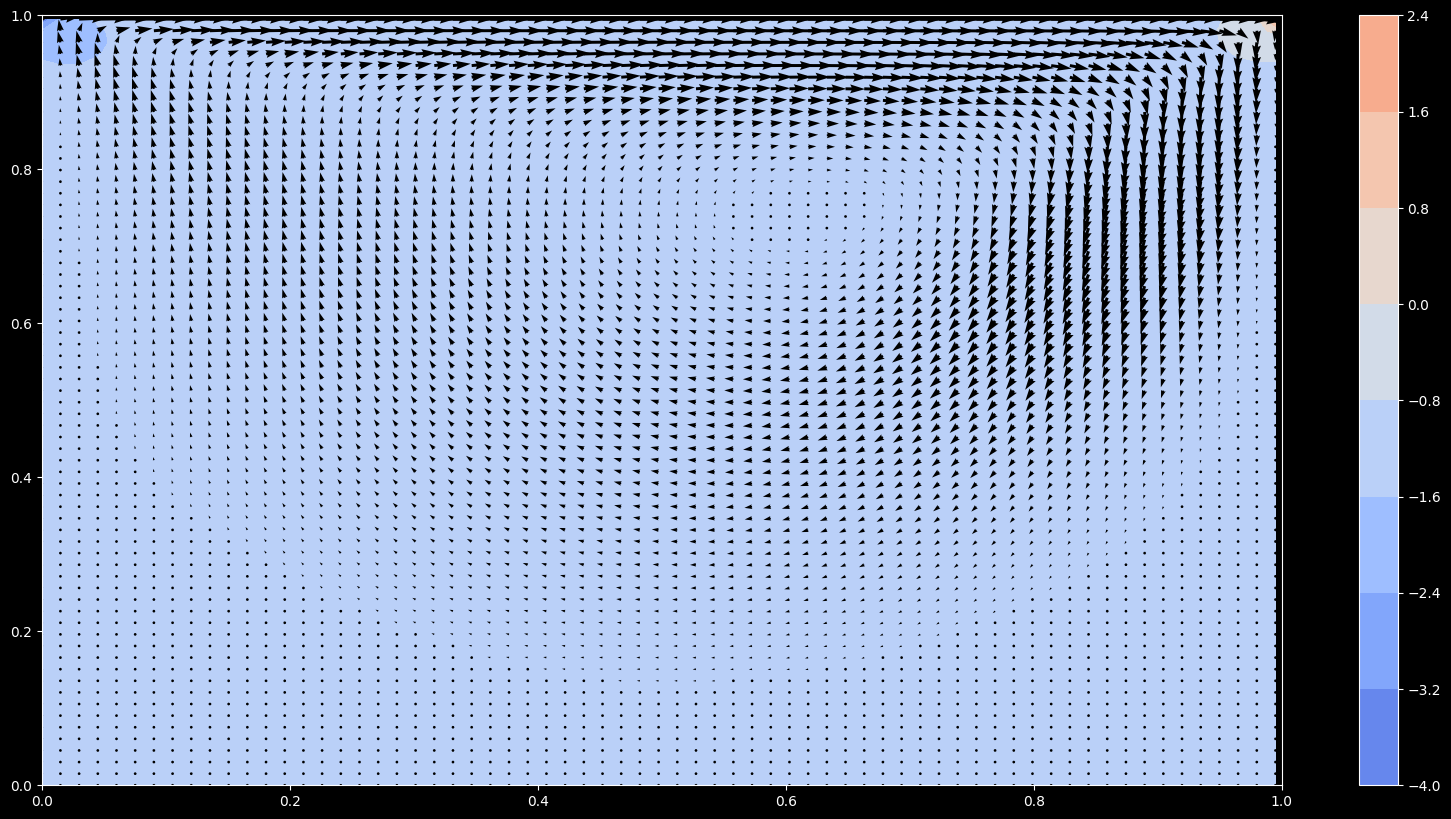

max p :  4.3194933
min p :  -4.5300493
[[5.42779028e-01 1.36364686e+00 1.41792479e+01]
 [3.64508927e-01 1.14575088e+00 1.18220177e+01]
 [2.58987218e-01 9.70160067e-01 9.96058846e+00]
 ...
 [4.06530546e-03 5.75104030e-03 6.15757070e-02]
 [4.96179890e-03 5.74003253e-03 6.23621233e-02]
 [5.25394967e-03 5.74607728e-03 6.27147257e-02]]


In [30]:
plt.clf
plt.style.use("dark_background")
plt.figure(figsize=(20, 10))
j=3
contour =plt.contourf(x_np[::j, ::j], y_np[::j, ::j], p_np[::j, ::j], cmap="coolwarm", vmin=p_np.min(), vmax=4.5)
contour.set_clim(-5,5)
colorbar=plt.colorbar()


plt.quiver(x_np[::j,::j], y_np[::j,::j] , u_np[::j,::j] , v_np[::j,::j] , color="black", scale=30)
plt.xlim((0, 1))
plt.ylim((0, 1))

plt.show()

print("max p : " , p_np.max() )
print("min p : " , p_np.min() )
print(loss_per_epoch)